# Product Analytics

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
# from pyspark.sql.functions import rank,col,sum
# from pyspark.sql.functions import hour, dayofmonth, dayofweek, year, month, when
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType


from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, MinMaxScaler, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.stat import Correlation


from xgboost.spark import SparkXGBClassifier


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
# Build Spark Session
spark = SparkSession.builder \
    .appName("Product-Analytics") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

25/03/05 01:27:15 WARN Utils: Your hostname, Richards-MacBook-Pro-67.local resolves to a loopback address: 127.0.0.1; using 192.168.0.12 instead (on interface en0)
25/03/05 01:27:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/05 01:27:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data pre-processing

In [3]:
# Read CSV into a Spark DF
df = spark.read.csv("product.csv",header=True,inferSchema=True)

In [4]:
num_rows = df.count()
print(f'Number of rows is {num_rows}')
df.printSchema()
df.show()

Number of rows is 8471220
root
 |-- order_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- page_id: string (nullable = true)
 |-- product: string (nullable = true)
 |-- site_version: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- target: integer (nullable = true)

+--------------------+--------------------+--------------------+----------------+------------+-------------------+------------+------+
|            order_id|             user_id|             page_id|         product|site_version|               time|       title|target|
+--------------------+--------------------+--------------------+----------------+------------+-------------------+------------+------+
|cfcd208495d565ef6...|c81e728d9d4c2f636...|6f4922f45568161a8...|        sneakers|     desktop|2019-01-11 09:24:43|banner_click|     0|
|c4ca4238a0b923820...|eccbc87e4b5ce2fe2...|4e732ced3463d06de...|        sneakers|     desktop|2019-01-09 09:38:5

In [5]:
df.select("title").distinct().show()
df.select("product").distinct().show()
df.select("site_version").distinct().show()

+------------+
|       title|
+------------+
| banner_show|
|banner_click|
|       order|
+------------+



+----------------+
|         product|
+----------------+
|        sneakers|
|sports_nutrition|
|         clothes|
|     accessories|
|         company|
+----------------+



+------------+
|site_version|
+------------+
|     desktop|
|      mobile|
+------------+



### Check for null values, duplicates, outliers in the DF

In [6]:
# Check for Null values 
df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()
# there is no null values

+--------+-------+-------+-------+------------+----+-----+------+
|order_id|user_id|page_id|product|site_version|time|title|target|
+--------+-------+-------+-------+------------+----+-----+------+
|       0|      0|      0|      0|           0|   0|    0|     0|
+--------+-------+-------+-------+------------+----+-----+------+



In [7]:
# Check for duplicate rows
total_rows = df.count()
distinct_rows = df.distinct().count()
if total_rows > distinct_rows:
    print(f"There are {total_rows - distinct_rows} duplicate rows.")
else:
    print("\n\n\n\nThere are no duplicate rows.")





There are no duplicate rows.


### Do some feature engineering

In [8]:
# Convert site version column to binary

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in [ "site_version"]]

for indexer in indexers:
    df = indexer.transform(df)


In [9]:
# Step 1: Get unique products
unique_products = df.select("product").distinct().rdd.flatMap(lambda x: x).collect()
# print("Unique Products:", unique_products)

# Step 2: Initialize columns of 0 for each product
for product in unique_products:
    df = df.withColumn(f"product_{product}", F.when(F.col("product") == product, 1).otherwise(0))


In [10]:
# Generate visit number for each row

# Define the window specification
window_spec = Window.partitionBy('user_id').orderBy('time')

# Apply the rank function within each group (user)
df = df.withColumn('visitNumber', F.rank().over(window_spec))

In [11]:
# Extracting time information

# 1. time_IsMorning (6:00 AM to 10:00 AM)
df = df.withColumn(
    'time_IsMorning', F.when((F.hour('time') >= 6) & (F.hour('time') < 10), 1).otherwise(0)
)

# 2. time_IsDaylight (10:00 AM to 4:00 PM)
df = df.withColumn(
    'time_IsDaylight', F.when((F.hour('time') >= 10) & (F.hour('time') < 16), 1).otherwise(0)
)

# 3. time_IsEvening (4:00 PM to 11:00 PM)
df = df.withColumn(
    'time_IsEvening', F.when((F.hour('time') >= 16) & (F.hour('time') < 23), 1).otherwise(0)
)

# 4. time_Hour (extract the hour)
df = df.withColumn(
    'time_Hour', F.hour('time')
)

# 5. time_Day (extract the day of the month)
df = df.withColumn(
    'time_Day', F.dayofmonth('time')
)

# 6. time_Week_Day (extract the weekday, starting from 1 for Monday)
df = df.withColumn(
    'time_Week_Day', (F.dayofweek('time') - 1).cast('int') + 1  # dayofweek returns 1 for Sunday, adjust to start from Monday as 1
)

# 7. time_Year_Month (create a YYYYMM format)
df = df.withColumn(
    'time_Year_Month', (F.year('time') * 100 + F.month('time')).cast('int')
)

### Drop columns

In [12]:
# Drop columns
df_final = df.drop("order_id", "page_id", "product", "site_version", "time", 
                   "title", "product_index", "user_id")

In [13]:
df_final.columns

['target',
 'site_version_index',
 'product_sneakers',
 'product_sports_nutrition',
 'product_clothes',
 'product_accessories',
 'product_company',
 'visitNumber',
 'time_IsMorning',
 'time_IsDaylight',
 'time_IsEvening',
 'time_Hour',
 'time_Day',
 'time_Week_Day',
 'time_Year_Month']

## Class Imbalance

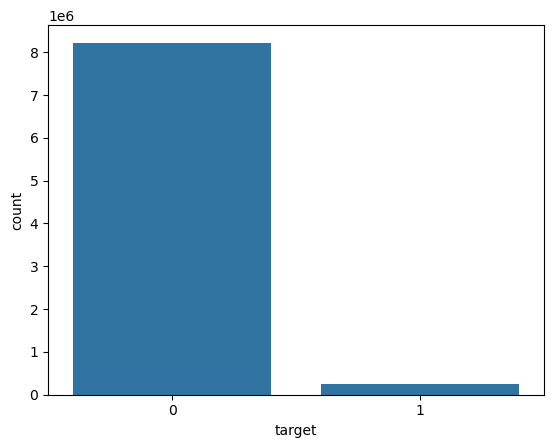

In [14]:
# Grouping by 'target' and counting occurrences
target_counts = df_final.groupBy('target').count().toPandas()

sns.barplot(x='target', y='count', data=target_counts)
plt.show()

### Class imbalance
There's a large class imbalance so we need to take that into account. We can either
1. Balance the data
2. Take the data into account by modifying loss function
   
I tend to not like balancing the data so I'll go with models of (2)

In [15]:
# Compute class weights (inverse frequency)

class_counts = df_final.groupBy("target").count().collect()
total_count = df_final.count()
class_weights = {row['target']: total_count / row['count'] for row in class_counts}

# Initialize df with weights
df_final = df_final.withColumn(
    "weight",
    F.when(F.col("target") == 0, class_weights[0])
    .otherwise(class_weights[1])
)

### Form feature vector

In [ ]:
# Form feature vector from leftover stuff

# Define the list of columns to exclude
exclude_cols = ["target", "weight"]

# Get all columns except those in `exclude_cols`
feature_cols = [col for col in df_final.columns if col not in exclude_cols]

# Use VectorAssembler to combine the remaining columns into a feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform the DataFrame
df_final = assembler.transform(df_final)

feature_columns = assembler.getInputCols()
print("Feature columns used in the vector:", feature_columns)

Feature columns used in the vector: ['site_version_index', 'product_sneakers', 'product_sports_nutrition', 'product_clothes', 'product_accessories', 'product_company', 'visitNumber', 'time_IsMorning', 'time_IsDaylight', 'time_IsEvening', 'time_Hour', 'time_Day', 'time_Week_Day', 'time_Year_Month']


In [28]:
# Step 2: Scale the feature vector
# Initialize StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# Fit the scaler to the data
scaler_model = scaler.fit(df_final)

# Transform the data to get scaled features
df_final = scaler_model.transform(df_final)


# EDA

## Heatmap of correlations

25/03/05 01:31:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/05 01:31:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


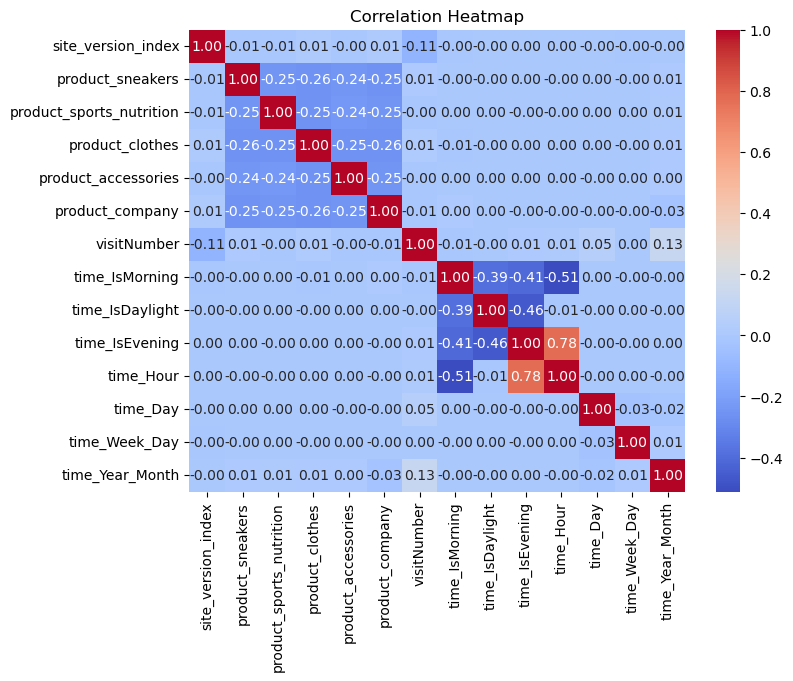

In [17]:
# Compute the correlation matrix using the Pearson method
correlation_matrix = Correlation.corr(df_final, 'features', 'pearson').head()[0]

# Convert the correlation matrix to a Pandas DataFrame for easier plotting
# Extract the correlation matrix and convert it to Pandas DataFrame
corr_array = correlation_matrix.toArray()
corr_df = pd.DataFrame(corr_array, columns=feature_columns, index=feature_columns)

# Plot the heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Heatmap")
plt.show()

### Check to see which product/banner has the highest rate of X

In [18]:

# Group by product and calculate the total count and count of 1s in target column
df_target_grouped = df.groupBy("product").agg(
    F.count("target").alias("total_count_target"),  # Total count of rows per product for target
    F.sum(F.when(F.col("target") == 1, 1).otherwise(0)).alias("count_1s")  # Count of 1s in target
)

# Group by product and calculate the total count and count of banner_clicks in the title column
df_click_grouped = df.groupBy("product").agg(
    F.count("title").alias("total_count_click"),  # Total count of rows per product for title
    F.sum(F.when(F.col("title") == 'banner_click', 1).otherwise(0)).alias("count_clicks")  # Count of banner_clicks
)

# Join both dataframes on the product column
df_combined = df_target_grouped.join(df_click_grouped, on="product", how="inner")

# Calculate the percentage of 1s in target and the percentage of banner_clicks in title
df_result = df_combined.withColumn(
    "percentage_1s", (F.col("count_1s") / F.col("total_count_target")) * 100
).withColumn(
    "percentage_clicks", (F.col("count_clicks") / F.col("total_count_click")) * 100
).withColumn(
    "percentage_1s|click", (F.col("count_1s") / F.col("count_clicks")) * 100
)

# Drop pointless info
df_result = df_result.drop( "count_1s", "total_count_click", "count_clicks")

# Show the result
df_result.show()

+----------------+------------------+------------------+------------------+-------------------+
|         product|total_count_target|     percentage_1s| percentage_clicks|percentage_1s|click|
+----------------+------------------+------------------+------------------+-------------------+
|        sneakers|           1703342|3.9756549183898473|10.719867178757994|  37.08679270082587|
|sports_nutrition|           1634625|1.4521373403685862| 8.865519614590504| 16.379607778191804|
|         clothes|           1786438| 6.309482892773217|12.348315474704412| 51.095899725741745|
|     accessories|           1621759|2.7470789432955205| 8.401618242907855|  32.69702173881134|
|         company|           1725056|               0.0| 8.395147751725162|                0.0|
+----------------+------------------+------------------+------------------+-------------------+



### Which site version

In [19]:

# Group by product and calculate the total count and count of 1s in target column
df_target_grouped = df.groupBy("site_version").agg(
    F.count("target").alias("total_count_target"),  # Total count of rows per product for target
    F.sum(F.when(F.col("target") == 1, 1).otherwise(0)).alias("count_1s")  # Count of 1s in target
)

# Group by product and calculate the total count and count of banner_clicks in the title column
df_click_grouped = df.groupBy("site_version").agg(
    F.count("title").alias("total_count_click"),  # Total count of rows per product for title
    F.sum(F.when(F.col("title") == 'banner_click', 1).otherwise(0)).alias("count_clicks")  # Count of banner_clicks
)

# Join both dataframes on the product column
df_combined = df_target_grouped.join(df_click_grouped, on="site_version", how="inner")

# Calculate the percentage of 1s in target and the percentage of banner_clicks in title
df_result = df_combined.withColumn(
    "percentage_1s", (F.col("count_1s") / F.col("total_count_target")) * 100
).withColumn(
    "percentage_clicks", (F.col("count_clicks") / F.col("total_count_click")) * 100
).withColumn(
    "percentage_1s|click", (F.col("count_1s") / F.col("count_clicks")) * 100
)

# Drop pointless info
df_result = df_result.drop( "count_1s", "total_count_click", "count_clicks")

# Show the result
df_result.show()

+------------+------------------+------------------+-----------------+-------------------+
|site_version|total_count_target|     percentage_1s|percentage_clicks|percentage_1s|click|
+------------+------------------+------------------+-----------------+-------------------+
|     desktop|           2382885| 5.589065355650819|4.828810454554038| 115.74414461391387|
|      mobile|           6088335|1.8977438002343825|11.72929873274056|  16.17951629910421|
+------------+------------------+------------------+-----------------+-------------------+



## Preliminary Conclusions

* The clothing banner has the highest clickthrough rate AND highest conversion rate. 
* The desktop site has a lower clickthrough rate but a higher conversion rate.


# Predictive Modeling (Using Classification)

## Logistic regression

In [20]:
# Logistic Regression with class weights
lr = LogisticRegression(labelCol="target", featuresCol="features", weightCol="weight")

# Train the model
model = lr.fit(df_final)

In [21]:
# Make predictions using the trained model
predictions = model.transform(df_final)

# Use BinaryClassificationEvaluator to evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction", metricName="areaUnderROC")

# Compute AUC
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.7159544395841737


In [22]:
model.coefficients

DenseVector([1.1749, 2.9021, 1.8571, 3.3061, 2.5038, -19.8217, 0.1697, -1.457, -0.9953, -1.0692, 0.0301, -0.0024, -0.0005, -0.0618])

In [23]:
feature_columns = assembler.getInputCols()
print("Feature columns used in the vector:", feature_columns)

Feature columns used in the vector: ['site_version_index', 'product_sneakers', 'product_sports_nutrition', 'product_clothes', 'product_accessories', 'product_company', 'visitNumber', 'time_IsMorning', 'time_IsDaylight', 'time_IsEvening', 'time_Hour', 'time_Day', 'time_Week_Day', 'time_Year_Month']


## XGBoost

In [24]:
# Define XGBoost Classifier
xgb = SparkXGBClassifier(features_col='features', label_col='target', weight_col="weight")

# Train the XGBoost model
xgb_model = xgb.fit(df_final)

# Make predictions using the trained model
predictions = xgb_model.transform(df_final)

2025-03-05 01:39:09,225 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-03-05 01:40:48,456 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[01:40:49] Task 0 got rank 0
2025-03-05 01:42:10,947 INFO XGBoost-PySpark: _fit Finished xgboost training!   


In [25]:
# Use BinaryClassificationEvaluator to evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction", metricName="areaUnderROC")

# Compute AUC
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

2025-03-05 01:42:43,342 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


AUC: 0.7410389012042662


Feature Importance (Weight):


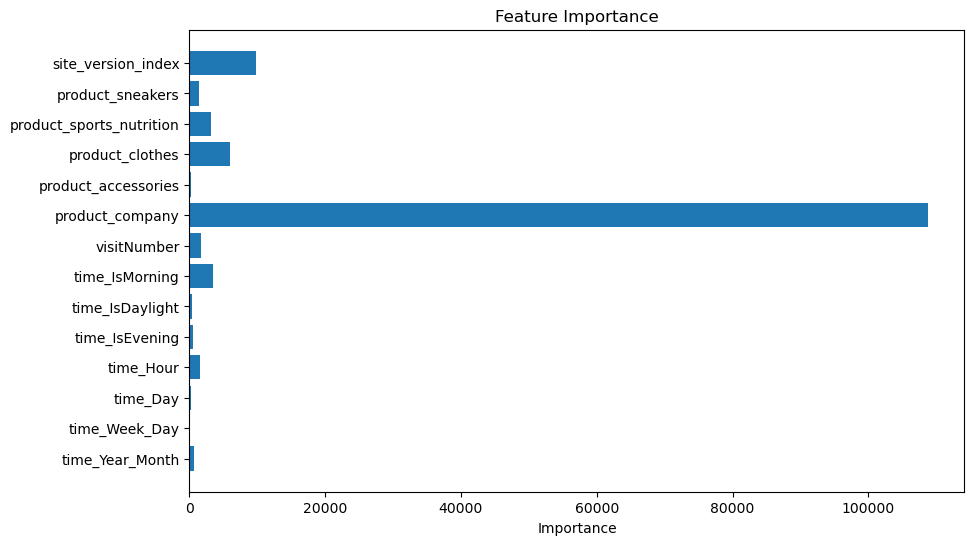

In [26]:
# Get the booster object (XGBoost model)
booster = xgb_model.get_booster()

# Get feature importance
importance = booster.get_score(importance_type='gain')  # You can use 'weight', 'gain', or 'cover'

# Show feature importance
importance_dict = {}
print("Feature Importance (Weight):")
for k, (feature, score) in enumerate(importance.items()):
    importance_dict[feature_columns[k]] = score
    # print(f"{feature_columns[k]}: {score}")
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Score"])
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()


# Clustering

25/03/05 02:08:24 WARN MemoryStore: Not enough space to cache rdd_743_7 in memory! (computed 100.8 MiB so far)
25/03/05 02:08:24 WARN BlockManager: Persisting block rdd_743_7 to disk instead.
25/03/05 02:08:24 WARN MemoryStore: Not enough space to cache rdd_743_5 in memory! (computed 100.8 MiB so far)
25/03/05 02:08:24 WARN BlockManager: Persisting block rdd_743_5 to disk instead.
25/03/05 02:08:47 WARN MemoryStore: Not enough space to cache rdd_743_2 in memory! (computed 151.8 MiB so far)
25/03/05 02:08:47 WARN MemoryStore: Not enough space to cache rdd_743_6 in memory! (computed 151.8 MiB so far)
25/03/05 02:08:47 WARN MemoryStore: Not enough space to cache rdd_743_1 in memory! (computed 151.8 MiB so far)
25/03/05 02:08:47 WARN BlockManager: Persisting block rdd_743_1 to disk instead.
25/03/05 02:08:47 WARN BlockManager: Persisting block rdd_743_2 to disk instead.
25/03/05 02:08:47 WARN BlockManager: Persisting block rdd_743_6 to disk instead.
25/03/05 02:08:47 WARN MemoryStore: Not 

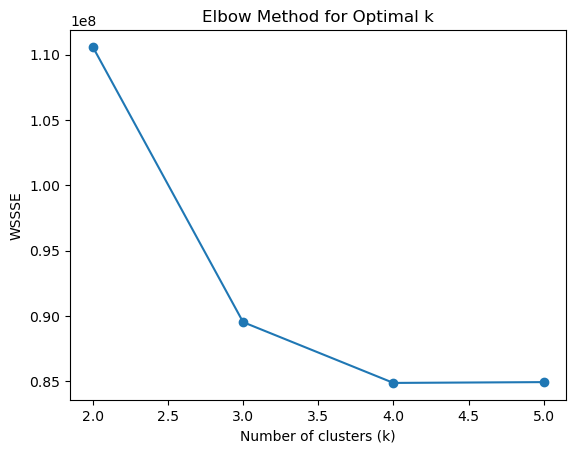

In [35]:
wssse_values = []
k_range = range(2, 6)  # Check for k = 2 to 6 clusters
for k in k_range:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures")  # Use scaledFeatures
    model = kmeans.fit(df_final)  # Fit the model on scaled data
    wssse = model.summary.trainingCost  # Calculate WSSSE
    wssse_values.append(wssse)

# Step 4: Plot the WSSSE values to visualize the elbow
plt.plot(k_range, wssse_values, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WSSSE")
plt.title("Elbow Method for Optimal k")
plt.show()

## Settled on K=4 clusters

In [36]:
kmeans = KMeans().setK(4).setSeed(1).setFeaturesCol("scaledFeatures")  # Use scaledFeatures
model = kmeans.fit(df_final)  # Fit the model on scaled data

25/03/05 02:25:25 WARN MemoryStore: Not enough space to cache rdd_1029_5 in memory! (computed 100.8 MiB so far)
25/03/05 02:25:25 WARN BlockManager: Persisting block rdd_1029_5 to disk instead.
25/03/05 02:25:25 WARN MemoryStore: Not enough space to cache rdd_1029_7 in memory! (computed 100.8 MiB so far)
25/03/05 02:25:25 WARN BlockManager: Persisting block rdd_1029_7 to disk instead.
25/03/05 02:26:11 WARN MemoryStore: Not enough space to cache rdd_1029_2 in memory! (computed 151.8 MiB so far)
25/03/05 02:26:10 WARN MemoryStore: Not enough space to cache rdd_1029_4 in memory! (computed 151.8 MiB so far)
25/03/05 02:26:11 WARN BlockManager: Persisting block rdd_1029_2 to disk instead.
25/03/05 02:26:11 WARN BlockManager: Persisting block rdd_1029_4 to disk instead.
25/03/05 02:26:13 WARN MemoryStore: Not enough space to cache rdd_1029_0 in memory! (computed 151.8 MiB so far)
25/03/05 02:26:13 WARN BlockManager: Persisting block rdd_1029_0 to disk instead.
25/03/05 02:26:13 WARN MemoryS

In [45]:
predictions = model.transform(df_final)

cluster_means = predictions.groupBy("prediction").agg(
    *[F.mean(col).alias(f"mean_{col}") for col in feature_columns+['target']]
)

# Show the results
cluster_means.show()


+----------+-----------------------+---------------------+-----------------------------+--------------------+------------------------+--------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+--------------------+--------------------+
|prediction|mean_site_version_index|mean_product_sneakers|mean_product_sports_nutrition|mean_product_clothes|mean_product_accessories|mean_product_company|  mean_visitNumber|mean_time_IsMorning|mean_time_IsDaylight|mean_time_IsEvening|    mean_time_Hour|     mean_time_Day|mean_time_Week_Day|mean_time_Year_Month|         mean_target|
+----------+-----------------------+---------------------+-----------------------------+--------------------+------------------------+--------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+--------------------+-----------------

# Conclusions